## Model Definition and Model Training

**This Notebook is for Non-Normalised Dataset**

### Data Dictionary

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
|Date |Date of incident	|
|Province/State |If there is a breakdown in states	|
|Lat |Latitude	|
|Lon |Longitude	|
|Confirmed |Confirmed cases	|
|Recovered |Recovered cases	|
|Deaths |Death cases	|
|Active |Active cases	|

## Summary and Results

Model performance indicator will be Root Mean Square Error (RMSE) to be as accurate as possible.

#### Results

| Algorithm      | MSE | RMSE | R2 |
|----------------|-----|------|----|
|Linear Regression | 2.038  | 1.428 |  0.319 |
|Extra Trees Regressor | 2.282 | 1.511 | 0.238 |
|XGBoost Regressor |1.656  | 1.287 | 0.447  |

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import shap

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.2)

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE, RFECV, SelectKBest, f_classif, f_regression, chi2

from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump, load

np.random.seed(0)

from pycaret.regression import *

pd.set_option('display.max_columns',50)
#pd.set_option('display.max_rows',100)
pd.set_option('display.width', 1000)
np.set_printoptions(suppress=True)

### Data Exploration and Analysis

In [2]:
df = pd.read_csv("malaysiacovid2.csv")

In [3]:
df.head()

,Date,Confirmed,Recovered,Deaths,Active,ConfirmDiff,DeathsDiff,RecoverDiff,ActiveDiff,Month,Day
0,2020-01-22,0,0,0,0,0.0,0.0,0.0,0.0,1,22
1,2020-01-23,0,0,0,0,0.0,0.0,0.0,0.0,1,23
2,2020-01-24,0,0,0,0,0.0,0.0,0.0,0.0,1,24
3,2020-01-25,3,0,0,3,3.0,0.0,0.0,3.0,1,25
4,2020-01-26,4,0,0,4,1.0,0.0,0.0,1.0,1,26


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         309 non-null    object 
 1   Confirmed    309 non-null    int64  
 2   Recovered    309 non-null    int64  
 3   Deaths       309 non-null    int64  
 4   Active       309 non-null    int64  
 5   ConfirmDiff  309 non-null    float64
 6   DeathsDiff   309 non-null    float64
 7   RecoverDiff  309 non-null    float64
 8   ActiveDiff   309 non-null    float64
 9   Month        309 non-null    int64  
 10  Day          309 non-null    int64  
dtypes: float64(4), int64(6), object(1)
memory usage: 26.7+ KB


In [5]:
df.describe(include='all')

,Date,Confirmed,Recovered,Deaths,Active,ConfirmDiff,DeathsDiff,RecoverDiff,ActiveDiff,Month,Day
count,309,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
unique,309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2020-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,10535.511327,8236.019417,111.669903,2187.822006,193.582524,1.116505,150.488673,41.977346,6.265372,15.857605
std,NaN,12082.498984,8826.720903,81.039279,3547.802649,359.375952,1.988445,306.753450,172.885226,2.943317,8.814048
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1382.000000,1.000000,1.000000
25%,NaN,4119.000000,1487.000000,65.000000,153.000000,7.000000,0.000000,6.000000,-12.000000,4.000000,8.000000
50%,NaN,8596.000000,8231.000000,121.000000,751.000000,33.000000,0.000000,28.000000,3.000000,6.000000,16.000000
75%,NaN,9583.000000,9143.000000,128.000000,1973.000000,150.000000,1.000000,96.000000,51.000000,9.000000,23.000000


In [6]:
df.shape

(309, 11)

In [7]:
df.columns

Index(['Date', 'Confirmed', 'Recovered', 'Deaths', 'Active', 'ConfirmDiff', 'DeathsDiff', 'RecoverDiff', 'ActiveDiff', 'Month', 'Day'], dtype='object')

### Drop unwanted features

In [8]:
df.drop(['Date', 'Confirmed', 'Recovered', 'Deaths', 'Active','ActiveDiff'],axis=1,inplace=True)

In [14]:
df.head()

,Month,Day,ConfirmDiff,RecoverDiff,DeathsDiff
0,1,22,0.0,0.0,0.0
1,1,23,0.0,0.0,0.0
2,1,24,0.0,0.0,0.0
3,1,25,3.0,0.0,0.0
4,1,26,1.0,0.0,0.0


In [10]:
df.columns

Index(['ConfirmDiff', 'DeathsDiff', 'RecoverDiff', 'Month', 'Day'], dtype='object')

In [11]:
df = df[['Month', 'Day','ConfirmDiff','RecoverDiff', 'DeathsDiff']]

In [13]:
df.head()

,Month,Day,ConfirmDiff,RecoverDiff,DeathsDiff
0,1,22,0.0,0.0,0.0
1,1,23,0.0,0.0,0.0
2,1,24,0.0,0.0,0.0
3,1,25,3.0,0.0,0.0
4,1,26,1.0,0.0,0.0


### Data Visualization

### Univariate Data Exploration

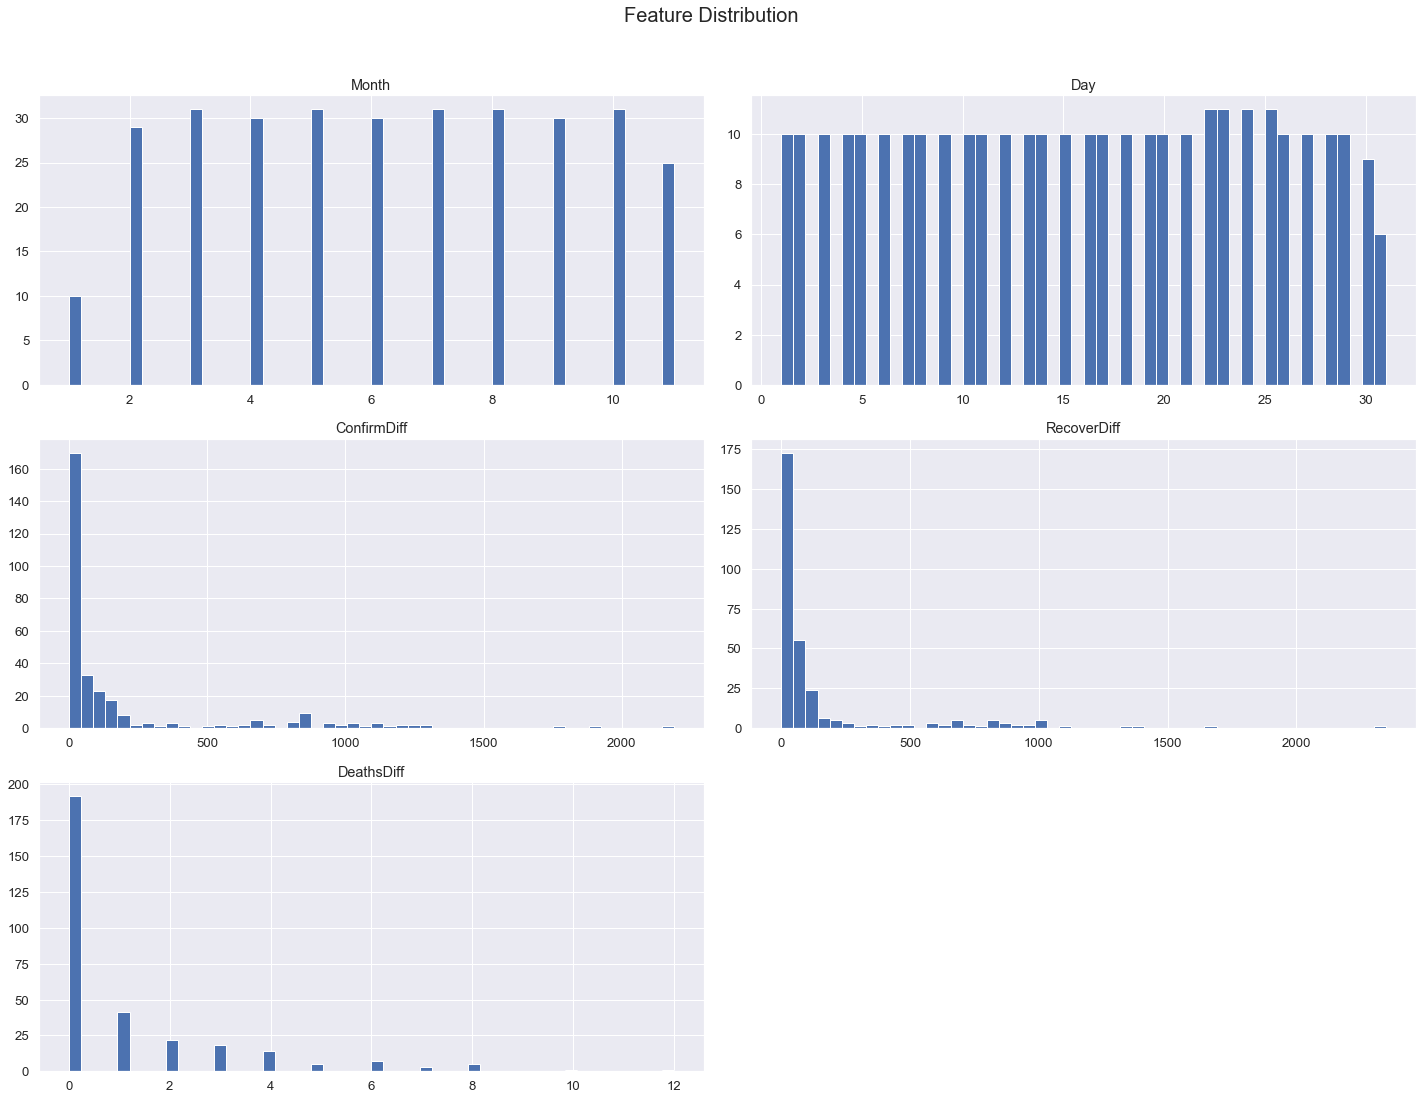

In [15]:
df.hist(bins=50, figsize=(20,15))
plt.suptitle('Feature Distribution', x=0.5, y=1.02, ha='center', fontsize=20)
plt.tight_layout()
plt.show()

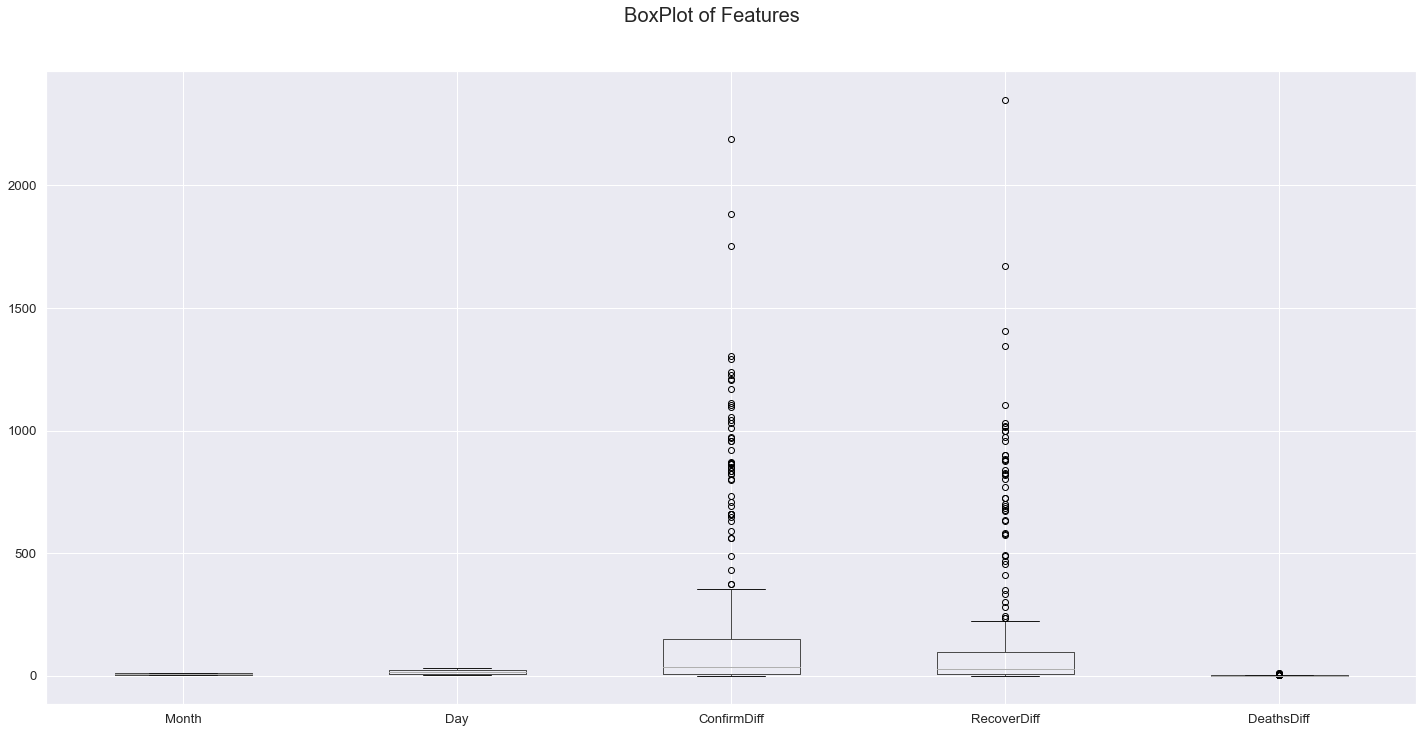

In [16]:
df.boxplot(figsize=(20,10))
plt.suptitle('BoxPlot of Features', x=0.5, y=1.02, ha='center', fontsize=20)
plt.tight_layout()
plt.show()

### Correlation

In [17]:
df.corr()

,Month,Day,ConfirmDiff,RecoverDiff,DeathsDiff
Month,1.000000,-0.098535,0.604269,0.545945,0.341420
Day,-0.098535,1.000000,0.002108,0.027499,0.035592
ConfirmDiff,0.604269,0.002108,1.000000,0.875959,0.641523
RecoverDiff,0.545945,0.027499,0.875959,1.000000,0.561145
DeathsDiff,0.341420,0.035592,0.641523,0.561145,1.000000


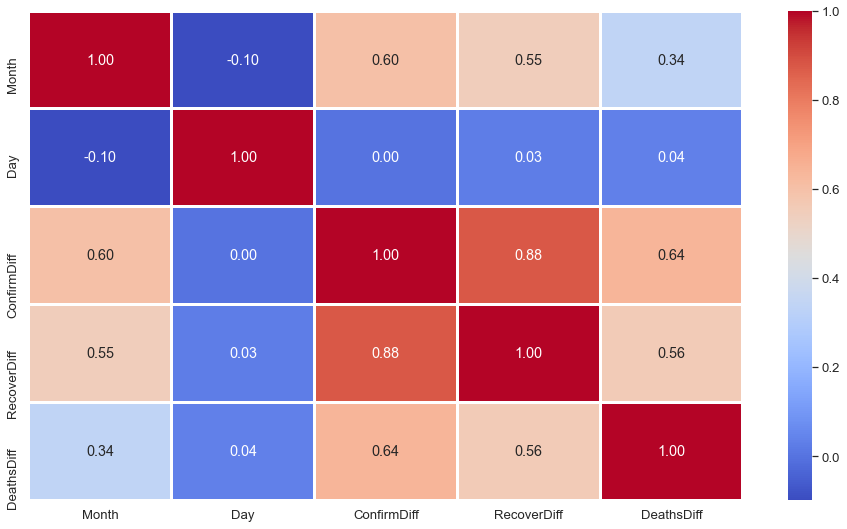

In [18]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

### Pairplots

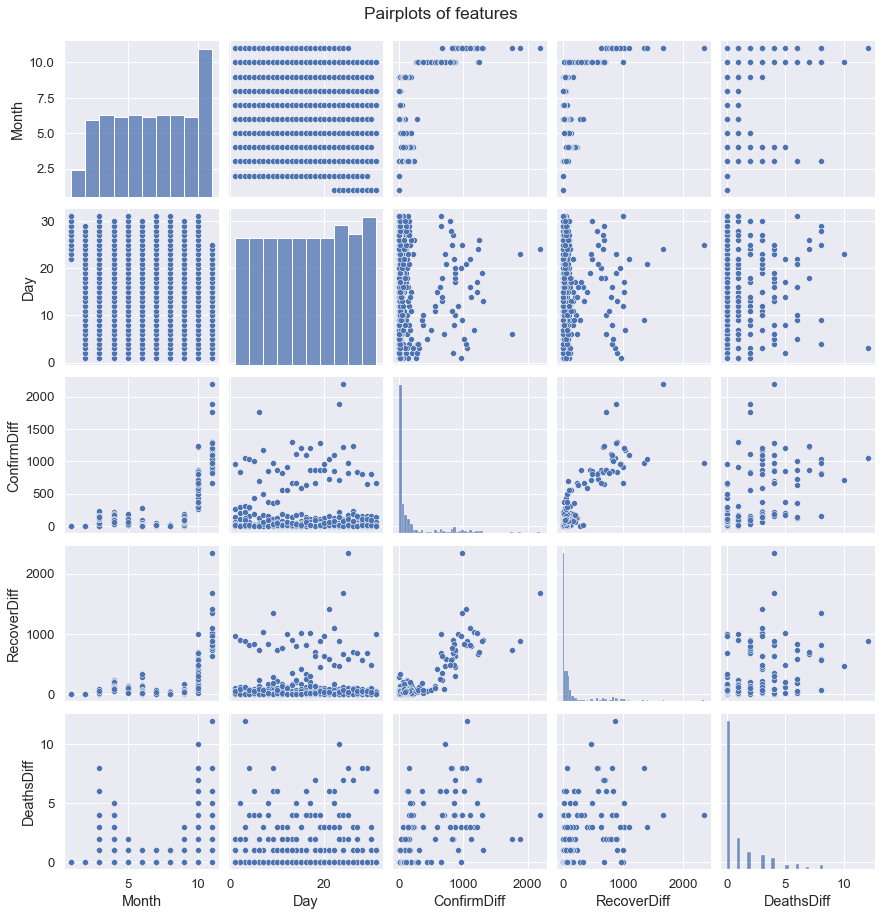

In [19]:
sns.pairplot(df)
plt.suptitle('Pairplots of features', x=0.5, y=1.02, ha='center', fontsize='large')
plt.show()

### Treat Duplicate Values

In [20]:
df.duplicated(keep='first').sum()

0

### Treat Outliers

In [21]:
df.describe()

,Month,Day,ConfirmDiff,RecoverDiff,DeathsDiff
count,309.000000,309.000000,309.000000,309.000000,309.000000
mean,6.265372,15.857605,193.582524,150.488673,1.116505
std,2.943317,8.814048,359.375952,306.753450,1.988445
min,1.000000,1.000000,0.000000,0.000000,0.000000
25%,4.000000,8.000000,7.000000,6.000000,0.000000
50%,6.000000,16.000000,33.000000,28.000000,0.000000
75%,9.000000,23.000000,150.000000,96.000000,1.000000
max,11.000000,31.000000,2188.000000,2348.000000,12.000000


#### No treatment of outliers needed

### Treat Data Types

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Month        309 non-null    int64  
 1   Day          309 non-null    int64  
 2   ConfirmDiff  309 non-null    float64
 3   RecoverDiff  309 non-null    float64
 4   DeathsDiff   309 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 12.2 KB


In [23]:
df["Month"] = df["Month"].astype("category")

In [24]:
df["Day"] = df["Day"].astype("category")

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Month        309 non-null    category
 1   Day          309 non-null    category
 2   ConfirmDiff  309 non-null    float64 
 3   RecoverDiff  309 non-null    float64 
 4   DeathsDiff   309 non-null    float64 
dtypes: category(2), float64(3)
memory usage: 9.9 KB


### Create and save processed dataset

In [26]:
#df.to_csv("traincovid.csv",index=False)

In [27]:
df["Month"].value_counts()

10    31
8     31
7     31
5     31
3     31
9     30
6     30
4     30
2     29
11    25
1     10
Name: Month, dtype: int64

In [28]:
df["Day"].value_counts()

23    11
25    11
24    11
22    11
6     10
11    10
10    10
9     10
8     10
7     10
16    10
13    10
5     10
4     10
3     10
2     10
12    10
1     10
14    10
15    10
17    10
18    10
19    10
20    10
21    10
26    10
27    10
28    10
29    10
30     9
31     6
Name: Day, dtype: int64

In [29]:
df2 = pd.get_dummies(data=df, drop_first=True)

In [30]:
df2.head()

,ConfirmDiff,RecoverDiff,DeathsDiff,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31
0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,3.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [31]:
df2.columns

Index(['ConfirmDiff', 'RecoverDiff', 'DeathsDiff', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8', 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15', 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_22', 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29', 'Day_30', 'Day_31'], dtype='object')

In [32]:
df2 = df2[['Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 
           'Month_10', 'Month_11', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8', 'Day_9', 
           'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15', 'Day_16', 'Day_17', 'Day_18', 
           'Day_19', 'Day_20', 'Day_21', 'Day_22', 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 
           'Day_28', 'Day_29', 'Day_30', 'Day_31', 'ConfirmDiff', 'RecoverDiff', 'DeathsDiff']]

In [33]:
df2.columns

Index(['Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8', 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15', 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_22', 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29', 'Day_30', 'Day_31', 'ConfirmDiff', 'RecoverDiff', 'DeathsDiff'], dtype='object')

In [34]:
df2.head()

,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31,ConfirmDiff,RecoverDiff,DeathsDiff
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.0,0.0,0.0


### Create and save processed dataset

In [35]:
#df2.to_csv("traincovid2.csv",index=False)

### Train Test Split

In [36]:
df2.shape

(309, 43)

In [37]:
X = df2.iloc[:,0:42]
y = df2.iloc[:,42]

In [38]:
X.values, y.values

(array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,    0., 1884.,  883.],
        [   0.,    0.,    0., ...,    0., 2188., 1673.],
        [   0.,    0.,    0., ...,    0.,  970., 2348.]]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  2.,  0.,  0.,  1.,  1.,  6.,  4.,  2.,  4.,  3.,
         3.,  1.,  8.,  2.,  6.,  2.,  5.,  3.,  4.,  4.,  1.,  1.,  2.,
         2.,  3.,  3.,  3.,  1.,  5.,  1.,  1.,  2.,  2.,  1.,  0.,  3.,
         1.,  2.,  1.,  2.,  0.,  1.,  1.,  0.,  2.,  1.,  0.,  2.,  0.,
         1.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  2.,  1.,  

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [40]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((231, 42), (78, 42), (231,), (78,))

### Feature Scaling

In [41]:
#X_train

In [42]:
#scaler = StandardScaler()

In [43]:
#minmax = MinMaxScaler()

In [44]:
#X_train_scaled = minmax.fit_transform(X_train)

In [45]:
#X_test_scaled = minmax.transform(X_test)

In [46]:
#X_train_scaled

In [47]:
#X_test_scaled

### Model Training

### Using PyCaret

In [48]:
pycaret = pd.read_csv("traincovid.csv")

In [49]:
exp_reg = setup(data = pycaret, target = 'DeathsDiff', session_id=0, normalize=False, 
                train_size=0.75, categorical_features=['Month','Day']) 

,Description,Value
0,session_id,0
1,Target,DeathsDiff
2,Original Data,"(309, 5)"
3,Missing Values,False
4,Numeric Features,2
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(231, 44)"


In [50]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,1.0044,2.6196,1.5108,0.2948,0.4911,0.5943,0.0130
en,Elastic Net,1.0042,2.6199,1.5109,0.2948,0.4909,0.5947,0.0120
knn,K Neighbors Regressor,0.8153,2.2315,1.4357,0.2762,0.4397,0.7076,0.0140
huber,Huber Regressor,0.8071,2.5101,1.4925,0.2610,0.4397,0.6261,0.0290
lightgbm,Light Gradient Boosting Machine,0.8245,2.0951,1.3988,0.2433,0.4450,0.6732,0.0260
br,Bayesian Ridge,0.9737,2.6449,1.5262,0.2267,0.4839,0.6006,0.0150
et,Extra Trees Regressor,0.7696,2.5556,1.5178,0.1749,0.4442,0.6348,0.1230
catboost,CatBoost Regressor,0.8570,2.3486,1.4838,0.1551,0.4441,0.6759,1.1140
rf,Random Forest Regressor,0.8110,2.3499,1.4723,0.1445,0.4474,0.6468,0.1410
ada,AdaBoost Regressor,1.0312,2.3350,1.4824,0.1330,0.5379,0.5177,0.0440


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=0,
      selection='cyclic', tol=0.0001, warm_start=False)

### Linear Regression

In [51]:
lr = LinearRegression()

In [52]:
model1 = lr.fit(X_train,y_train)

In [53]:
model1

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [54]:
lrprediction = model1.predict(X_test)

In [55]:
lrprediction

array([ 1.52302928,  0.52206879, -0.72297798,  0.63594962,  0.80806581,
       -0.3672057 ,  3.11115833,  0.63505182,  0.19810741,  1.9885116 ,
        2.17430917,  1.75831649, -0.5606298 ,  1.29492258, -0.28667605,
       -0.25969866, -0.0579919 ,  0.40014286, -0.0264301 , -0.118329  ,
        0.90519578, -0.6247919 ,  1.29413271,  1.1014569 , -0.1272126 ,
        1.20515671,  1.89062302,  0.32272939,  0.91263411,  1.41336108,
        0.30666462,  0.31243144,  2.98305746,  0.15288449,  0.6306367 ,
       -0.41244754,  0.70707757,  2.91743896,  0.00654834, -0.12224363,
        1.25507736,  1.35140372,  0.28827555,  0.24357661,  0.21489345,
       -0.36687873, -0.81089688,  0.83234452,  2.7627294 , -0.03140478,
        0.38029692,  4.80719401,  1.44298252, -0.80238205,  1.34335525,
        0.27719264,  2.67624502,  0.27601275,  1.08075557, -0.20336378,
       -0.51952615,  1.06713293,  0.42887705,  0.02500505,  2.31610025,
        2.51743377, -0.72666368, -0.17666269,  0.98344387,  0.09

In [56]:
lrprediction.round()

array([ 2.,  1., -1.,  1.,  1., -0.,  3.,  1.,  0.,  2.,  2.,  2., -1.,
        1., -0., -0., -0.,  0., -0., -0.,  1., -1.,  1.,  1., -0.,  1.,
        2.,  0.,  1.,  1.,  0.,  0.,  3.,  0.,  1., -0.,  1.,  3.,  0.,
       -0.,  1.,  1.,  0.,  0.,  0., -0., -1.,  1.,  3., -0.,  0.,  5.,
        1., -1.,  1.,  0.,  3.,  0.,  1., -0., -1.,  1.,  0.,  0.,  2.,
        3., -1., -0.,  1.,  0.,  3.,  0.,  1.,  1.,  2.,  3.,  3.,  1.])

### Model Evaluation

In [57]:
mse = mean_squared_error(y_test,lrprediction.round())
mse

2.0384615384615383

In [58]:
rmse = np.sqrt(mse)
rmse

1.427747014866968

In [59]:
r2score = r2_score(y_test,lrprediction.round())
r2score

0.31916996047430835

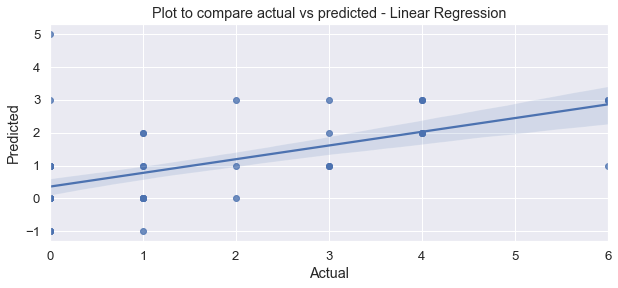

In [60]:
fig, ax = plt.subplots(figsize=(10,4))
sns.regplot(x=y_test, y=lrprediction.round(), ax=ax)
plt.title("Plot to compare actual vs predicted - Linear Regression")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

### Extra Trees Regressor

In [61]:
et = ExtraTreesRegressor()

In [62]:
model2 = et.fit(X_train,y_train)

In [63]:
model2

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [64]:
etprediction = model2.predict(X_test)

In [65]:
etprediction

array([0.17, 0.  , 0.  , 0.  , 0.  , 0.03, 3.21, 0.8 , 0.  , 1.71, 2.62,
       1.28, 0.02, 0.  , 0.  , 0.01, 0.37, 0.32, 0.  , 0.48, 0.  , 0.  ,
       1.16, 0.28, 0.  , 0.  , 2.32, 0.46, 0.05, 1.96, 0.  , 0.  , 0.03,
       0.11, 0.02, 0.  , 0.  , 2.07, 0.  , 0.11, 0.03, 0.23, 0.08, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.29, 0.  , 0.  , 4.35, 0.72, 0.  , 0.38,
       0.  , 2.5 , 0.  , 0.04, 0.  , 0.  , 0.04, 0.  , 0.  , 1.16, 1.46,
       0.  , 0.05, 0.44, 0.  , 1.54, 0.65, 0.  , 0.  , 1.79, 2.  , 1.89,
       0.67])

In [66]:
etprediction.round()

array([0., 0., 0., 0., 0., 0., 3., 1., 0., 2., 3., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       4., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 2., 1., 0., 0., 2., 2., 2., 1.])

### Model Evaluation

In [67]:
mse = mean_squared_error(y_test,etprediction.round())
mse

2.282051282051282

In [68]:
rmse = np.sqrt(mse)
rmse

1.5106459817082498

In [69]:
r2score = r2_score(y_test,etprediction.round())
r2score

0.2378129117259552

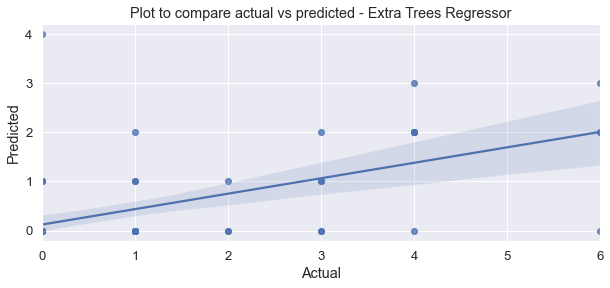

In [70]:
fig, ax = plt.subplots(figsize=(10,4))
sns.regplot(x=y_test, y=etprediction.round(), ax=ax)
plt.title("Plot to compare actual vs predicted - Extra Trees Regressor")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

### Using XGBoost (Scikit-Learn)

### Using RandomSearchCV

In [71]:
model3 = XGBRegressor(random_state=0, n_estimators=100, objective='reg:squarederror')

In [72]:
parameters = {'max_depth': np.arange(3,10,1),
              'eta': np.arange(0.05,0.3,0.05),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,10,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1),
              'reg_alpha':np.arange(0,1,0.1),
              'reg_lambda':np.arange(0,1,0.1)
             }

In [73]:
randm = RandomizedSearchCV(estimator=model3, param_distributions = parameters, cv = 5, n_iter = 20, 
                           n_jobs=-1, scoring='neg_root_mean_squared_error')

In [74]:
randm.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_...
                                        'min_child_weight': array([1, 2, 3]),
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900]),
  

In [75]:
randm.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eta=0.05, gamma=4,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.0500000007, max_delta_step=0, max_depth=5,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0,
             reg_alpha=0.7000000000000001, reg_lambda=0.30000000000000004,
             scale_pos_weight=1, subsample=0.5, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [76]:
randm.best_score_

-1.3828418002128893

In [77]:
randm.best_params_

{'subsample': 0.5,
 'reg_lambda': 0.30000000000000004,
 'reg_alpha': 0.7000000000000001,
 'n_estimators': 400,
 'min_child_weight': 3,
 'max_depth': 5,
 'gamma': 4,
 'eta': 0.05,
 'colsample_bytree': 0.6}

### Final Model

In [78]:
xgbmodel = XGBRegressor(random_state=0, n_estimators=400, objective='reg:squarederror',
                       subsample=0.5,reg_lambda=0.3,reg_alpha=0.7,min_child_weight=3,max_depth=5,
                       gamma=4, eta=0.05,colsample_bytree=0.6)

In [79]:
xgbmodel.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='rmse',early_stopping_rounds=10)

[0]	validation_0-rmse:1.75821
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.71623
[2]	validation_0-rmse:1.68752
[3]	validation_0-rmse:1.64542
[4]	validation_0-rmse:1.62503
[5]	validation_0-rmse:1.58318
[6]	validation_0-rmse:1.56379
[7]	validation_0-rmse:1.54993
[8]	validation_0-rmse:1.52237
[9]	validation_0-rmse:1.49689
[10]	validation_0-rmse:1.47791
[11]	validation_0-rmse:1.46083
[12]	validation_0-rmse:1.43904
[13]	validation_0-rmse:1.43089
[14]	validation_0-rmse:1.41257
[15]	validation_0-rmse:1.39626
[16]	validation_0-rmse:1.38596
[17]	validation_0-rmse:1.37691
[18]	validation_0-rmse:1.37286
[19]	validation_0-rmse:1.36382
[20]	validation_0-rmse:1.35836
[21]	validation_0-rmse:1.35815
[22]	validation_0-rmse:1.35958
[23]	validation_0-rmse:1.35307
[24]	validation_0-rmse:1.35303
[25]	validation_0-rmse:1.34221
[26]	validation_0-rmse:1.33919
[27]	validation_0-rmse:1.33155
[28]	validation_0-rmse:1.33006
[29]	validation_0-rmse:1.33051
[30]	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eta=0.05, gamma=4,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.0500000007, max_delta_step=0, max_depth=5,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0.7,
             reg_lambda=0.3, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [80]:
y_pred = xgbmodel.predict(X_test)

In [81]:
y_pred

array([1.693808  , 0.13319057, 0.05102912, 0.20768976, 0.20737144,
       0.24536291, 2.4978304 , 0.986519  , 0.07461962, 2.6818886 ,
       3.4523032 , 0.5945045 , 0.21168348, 0.43464845, 0.07461962,
       0.43183863, 0.20026293, 1.6112388 , 0.13319057, 2.257338  ,
       0.16788667, 0.07461962, 0.8828086 , 0.7581678 , 0.13319057,
       0.35158795, 1.9784685 , 0.13319057, 0.33965206, 2.2176018 ,
       0.13319057, 0.14977092, 2.1358585 , 0.3020173 , 0.31540662,
       0.12845254, 0.08497405, 4.5722485 , 0.15236476, 0.22618872,
       0.30875778, 2.0225163 , 0.1952821 , 0.07461962, 0.13319057,
       0.13319057, 0.11582598, 0.19766909, 1.9202349 , 0.12877086,
       0.20026293, 3.6903598 , 0.86935675, 0.13319057, 1.9299408 ,
       0.08497405, 3.348646  , 0.07461962, 0.586531  , 0.07461962,
       0.07461962, 0.5962136 , 0.25558794, 0.18085134, 0.89771414,
       1.0833393 , 0.09924564, 0.15694445, 1.6898073 , 0.08497405,
       2.3818989 , 0.12845254, 0.35158795, 0.39547715, 2.61681

In [82]:
y_pred.round()

array([2., 0., 0., 0., 0., 0., 2., 1., 0., 3., 3., 1., 0., 0., 0., 0., 0.,
       2., 0., 2., 0., 0., 1., 1., 0., 0., 2., 0., 0., 2., 0., 0., 2., 0.,
       0., 0., 0., 5., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       4., 1., 0., 2., 0., 3., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
       2., 0., 2., 0., 0., 0., 3., 4., 3., 1.], dtype=float32)

### Model Evaluation

In [83]:
mse = mean_squared_error(y_test,y_pred)
mse

1.655666687719013

In [84]:
rmse = np.sqrt(mse)
rmse

1.2867271224774166

In [85]:
r2score = r2_score(y_test,y_pred)
r2score

0.4470204145760609

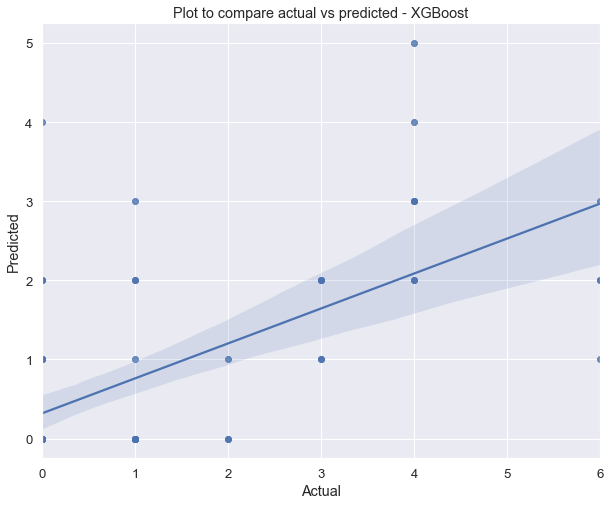

In [108]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred.round(), ax=ax)
plt.title("Plot to compare actual vs predicted - XGBoost")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

### Plot Feature Importances (Extra Tree and XGBoost)

In [87]:
et.feature_importances_

array([0.00002371, 0.01385562, 0.03296161, 0.00464944, 0.00149913,
       0.00098501, 0.00020326, 0.00288917, 0.09225506, 0.06298913,
       0.00828217, 0.07013692, 0.02320224, 0.01227223, 0.00075352,
       0.00315433, 0.01444801, 0.02448371, 0.00714466, 0.00274756,
       0.00176685, 0.00506808, 0.01110173, 0.00147041, 0.00071154,
       0.00750516, 0.00548574, 0.00214961, 0.00813984, 0.00454469,
       0.00369115, 0.04312089, 0.00354092, 0.00839973, 0.00377258,
       0.00924342, 0.00740653, 0.02676879, 0.00381528, 0.02986567,
       0.28322831, 0.15026656])

In [88]:
feat_importances = pd.Series(et.feature_importances_, index=X.columns)

In [89]:
feat_importances

Month_2        0.000024
Month_3        0.013856
Month_4        0.032962
Month_5        0.004649
Month_6        0.001499
Month_7        0.000985
Month_8        0.000203
Month_9        0.002889
Month_10       0.092255
Month_11       0.062989
Day_2          0.008282
Day_3          0.070137
Day_4          0.023202
Day_5          0.012272
Day_6          0.000754
Day_7          0.003154
Day_8          0.014448
Day_9          0.024484
Day_10         0.007145
Day_11         0.002748
Day_12         0.001767
Day_13         0.005068
Day_14         0.011102
Day_15         0.001470
Day_16         0.000712
Day_17         0.007505
Day_18         0.005486
Day_19         0.002150
Day_20         0.008140
Day_21         0.004545
Day_22         0.003691
Day_23         0.043121
Day_24         0.003541
Day_25         0.008400
Day_26         0.003773
Day_27         0.009243
Day_28         0.007407
Day_29         0.026769
Day_30         0.003815
Day_31         0.029866
ConfirmDiff    0.283228
RecoverDiff    0

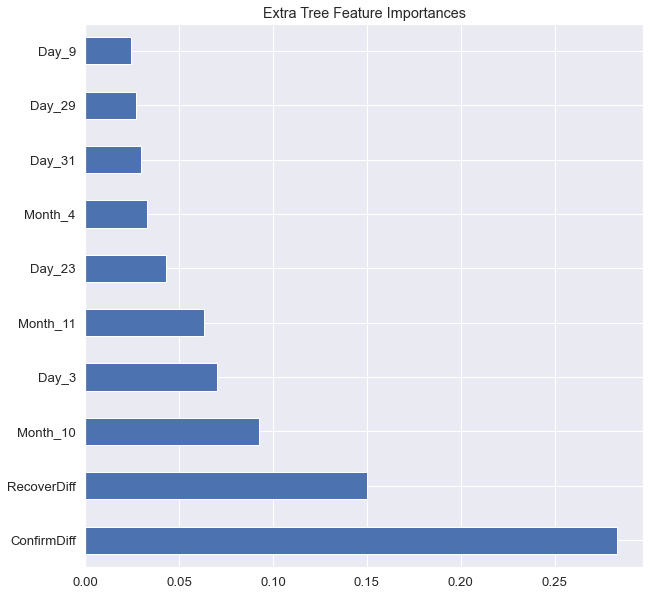

In [90]:
feat_importances.nlargest(10).plot(kind='barh', figsize=(10,10))
plt.title('Extra Tree Feature Importances')
plt.show()

In [91]:
X.columns

Index(['Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8', 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15', 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_22', 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29', 'Day_30', 'Day_31', 'ConfirmDiff', 'RecoverDiff'], dtype='object')

In [92]:
xgbmodel.get_booster().feature_names = ['Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8', 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15', 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_22', 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29', 'Day_30', 'Day_31', 'ConfirmDiff', 'RecoverDiff']

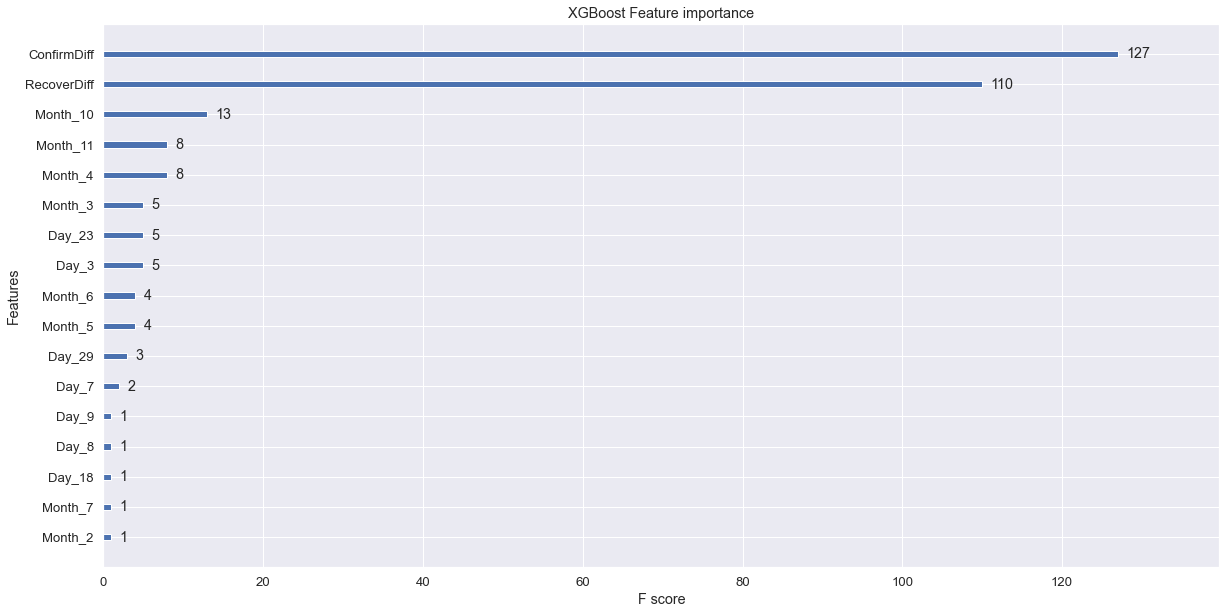

In [93]:
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbmodel.get_booster(),ax=ax,title='XGBoost Feature importance')
plt.show()

### Cross-Validation

In [94]:
cv = cross_val_score(xgbmodel,X,y,cv=5,verbose=1,scoring='neg_root_mean_squared_error')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished


In [95]:
cv.mean()

-1.4765106892218895

### XGBoost Model Prediction on Test Dataset

In [98]:
testref = pd.read_csv("testcovid.csv")

In [99]:
testref

,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,...,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31,ConfirmDiff,RecoverDiff,DeathsDiff
0,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,935.0,2555.0,3.0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1109.0,1148.0,2.0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1315.0,1110.0,4.0


In [100]:
testdata = pd.read_csv("testcovid2.csv")

In [101]:
testdata

,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,...,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31,ConfirmDiff,RecoverDiff
0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,935,2555
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1109,1148
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1315,1110


In [102]:
testprediction = xgbmodel.predict(testdata)

In [104]:
testprediction

array([2.6429937, 3.0189664, 2.5625987], dtype=float32)

In [105]:
testprediction.round()

array([3., 3., 3.], dtype=float32)

In [106]:
testref["DeathsDiff"]

0    3.0
1    2.0
2    4.0
Name: DeathsDiff, dtype: float64

### Save the Model

In [107]:
filename = 'covidmodelNN.sav'
dump(xgbmodel,open(filename,'wb'))